# The basics of Bayesian optimization

Many real-world problems involve optimization of functions which are difficult, or costly, to evaluate. For instance, in deep learning, finding the optimal hyperparameters and architecture of a neural network is a cumbersome process that should ideally be automated with as little fuction evaluations (i.e. training the networks) as possible.

For problems like these, Bayesian optimization (BO) offers a unifying framework where the function to evaluate is approximated using a surrogate model, for instance a Gaussian process. In this notebook, we introduce the basics of BO.

We load some libraries first.

In [1]:
suppressMessages({    
    library(pracma)
    library(rdist)
    library(tidyverse)    
    library(colorspace)    
    library(rstan)
    library(bayesplot)
})

set.seed(23)

In [2]:
scatterplot <- function(
    x.true, y.true, f_star=NULL, f_star_var=NULL, data=NULL) {
    df <- data.frame(x=x.true, y=y.true)
   
    g <- ggplot() +       
        theme(axis.line.x = element_line(color="black", size = .25),
              axis.line.y = element_line(color="black", size = .25))

    if (!is.null(f_star) && !is.null(f_star_var)) {
        df_star <- data.frame(
            x=x.true,
            y=f_star, 
            lower=f_star - sqrt(f_star_var), 
            upper=f_star + sqrt(f_star_var))
        g <- g + 
            geom_ribbon(data=df_star, aes(x, ymin = lower, ymax = upper, fill="#DCBCBC")) +             
            geom_line(data=df_star, aes(x, y, color="darkred"))
    }
    if (!is.null(data)) {
        g <- g + geom_point(data=data, aes(x, y, color="darkred")) 
    }
    
    g + 
     geom_line(data=df, aes(x, y, color="darkgrey")) +
     scale_color_manual(
            breaks = c("darkgrey", "darkred", "black"), 
            labels = c("Function to optimize", "Posterior", "Acquisition function"),
            values = c("darkgrey", "darkred", "black")
        ) +
        scale_fill_manual(
            breaks = c("lightgrey", "darkred", "#DCBCBC"),
            values = c("lightgrey", "darkred", "#DCBCBC")
        ) +
    labs(color = "Legend") +
    guides(fill=FALSE)
}

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstration BO on the example function below.

In [3]:
f <- function(x) cos(4 * x) + exp(-(x ** 2) / 2)

Without loss of generality, we constrain the optimization on a set of $n$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code.

In [4]:
n <- 1000

x.init = seq(-5, 5, length.out = n)
y.init = f(x.init)

Below is the function to optimize:

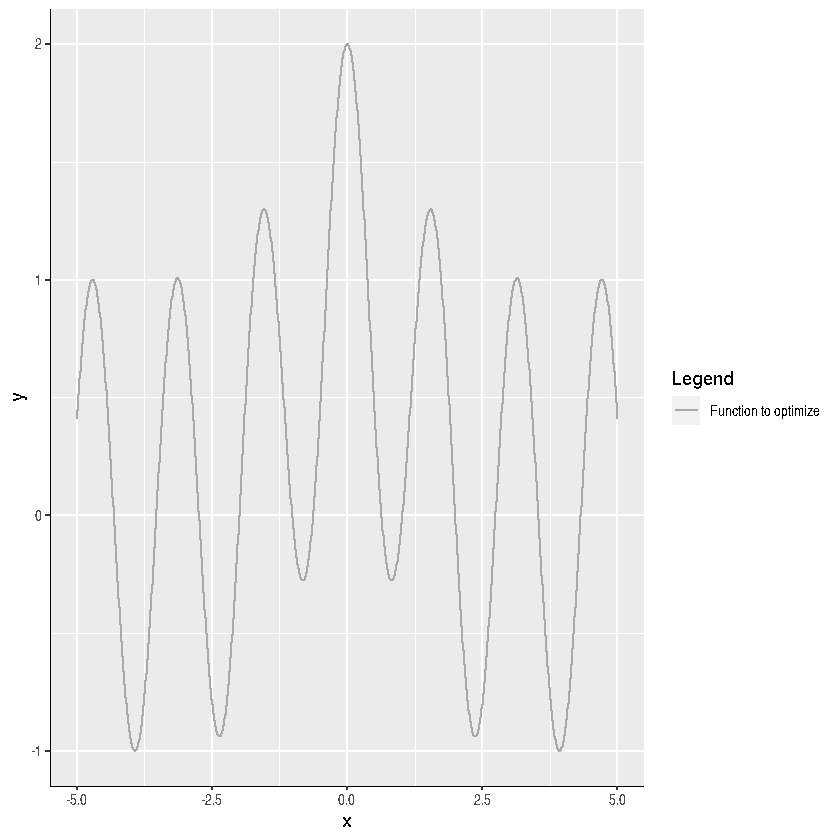

In [5]:
scatterplot(x.init, y.init)

To optimize this function, we define functions to fit a surrogate model and make a predict using the model fit. We use Stan to implement the surrogate model for which we use a Gaussian process.

In [6]:
surrogate.model.file <- "_models/bo-surrogate.stan"
cat(readLines(surrogate.model.file), sep="\n")

data {
	int<lower=1> N;
	real x[N];
	vector[N] y;

	int<lower=1> N_star;
	real x_star[N_star];

	real<lower=0> rho;
	real<lower=0> alpha;
	real<lower=0> sigma;
}

parameters {}

model {}

generated quantities {
	vector[N_star] f_star;
	vector[N_star] f_star_cov;

    {
      matrix[N, N] K =  cov_exp_quad(x, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N));
      matrix[N, N] L_K = cholesky_decompose(K);

      vector[N] L_K_div_y = mdivide_left_tri_low(L_K, y);
      vector[N] K_div_y = mdivide_right_tri_low(L_K_div_y', L_K)';
      
      matrix[N, N_star] k_x_x_star = cov_exp_quad(x, x_star, alpha, rho);
      
     
      matrix[N, N_star] v_pred = mdivide_left_tri_low(L_K, k_x_x_star);
      matrix[N_star, N_star] cov_f2 = cov_exp_quad(x_star, alpha, rho) - v_pred' * v_pred
		+ diag_matrix(rep_vector(1e-10, N_star));

		f_star = (k_x_x_star' * K_div_y);
		f_star_cov = diagonal(cov_f2);
	}

}


In [7]:
gp <- stan_model(file = surrogate.model.file)

In [67]:
predict.gp <- function(gp, x, y, x.star) {
    dat <- list(
        N=length(x),
        x=array(x),
        y=array(y),
        N_star=length(x.star),
        x_star=array(x.star),
        rho=1,
        alpha=1,
        sigma=1
    )
    
    pred <- rstan::sampling(gp, dat, chains=1, algorithm="Fixed_param", iter=1, refresh=-1)

    ext <- rstan::extract(pred)
    f.star <- as.vector(ext$f_star)
    f.star.var <- as.vector(ext$f_star_cov)
    
    
    list(f.star, f.star.var)
}

In [14]:
. <- predict.gp(gp, x.init[1], y.init[1], x.init)


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022224 seconds (Sampling)
Chain 1:                0.022224 seconds (Total)
Chain 1: 


As acquisition function we use the upper confidence bound.

In [17]:
acquisition.function <- function(gp, x.d, y.d, x.init, conf) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]
    ucb <- f.star + conf * sqrt(f.star.var)
    ucb
}

Finally, we define a function that proposes the next point to evaluate.

In [43]:
acquire <- function(x.d, y.d, x.init, conf=2.0) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]

    ucb <- acquisition.function(gp, x.d, y.d, x.init, conf)
    x.next <- x.init[which.max(ucb)]
    list(x.next=x.next, ucb=ucb, f.star=f.star, f.star.var=f.star.var)
}    

We start with a random point on the interval defined above and query it against the function that we want to evaluate

In [44]:
set.seed(23)

x.d <- runif(1, -5, 5)
y.d <- f(x.d)

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [45]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.var


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.024961 seconds (Sampling)
Chain 1:                0.024961 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022347 seconds (Sampling)
Chain 1:                0.022347 seconds (Total)
Chain 1: 


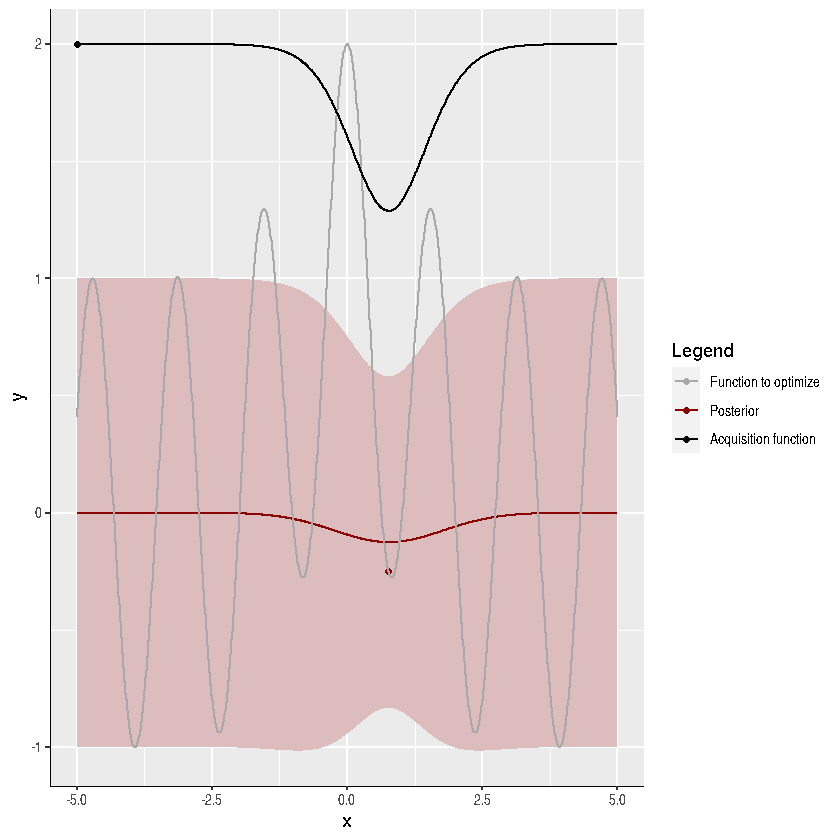

In [47]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [48]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [49]:
iter <- acquire(x.d, y.d, x.init)


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023048 seconds (Sampling)
Chain 1:                0.023048 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021074 seconds (Sampling)
Chain 1:                0.021074 seconds (Total)
Chain 1: 


In [50]:
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

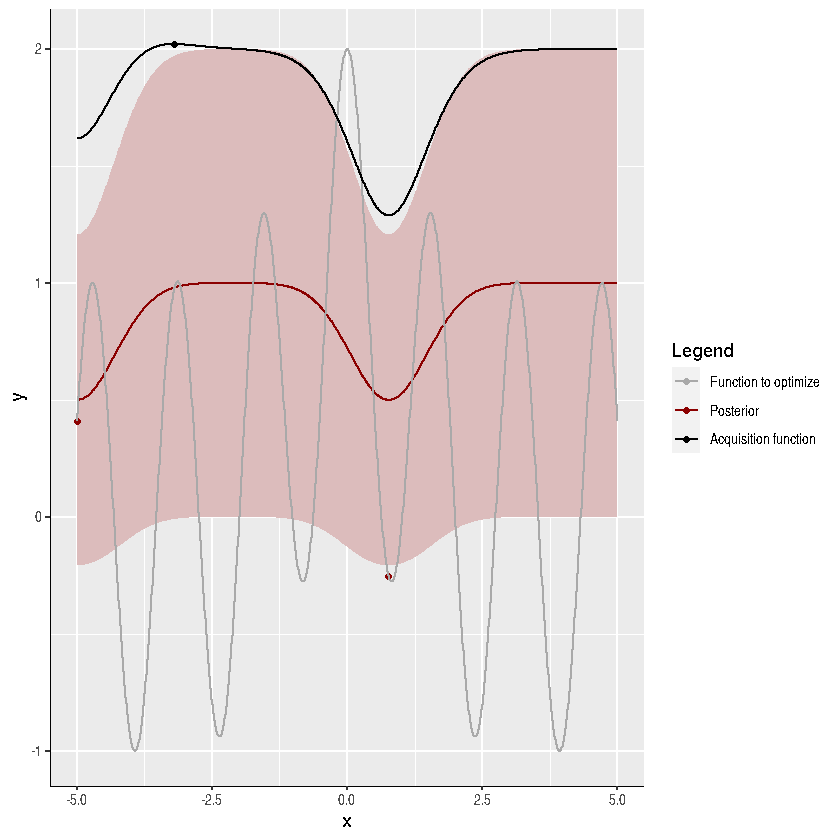

In [26]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [51]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [52]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023934 seconds (Sampling)
Chain 1:                0.023934 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021513 seconds (Sampling)
Chain 1:                0.021513 seconds (Total)
Chain 1: 


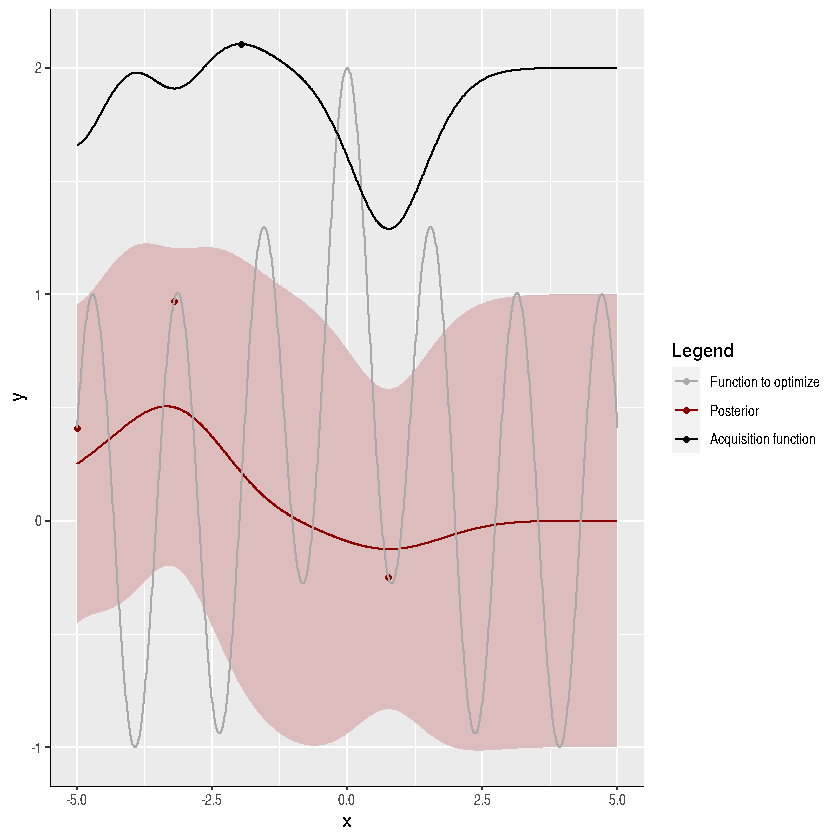

In [53]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [54]:
for (i in seq(20)) {
    y.n <- f(x.n)
    x.d <- c(x.d, x.n)
    y.d <- c(y.d, y.n)
    iter <- acquire(x.d, y.d, x.init)
    x.n <- iter$x.next
}


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.02088 seconds (Sampling)
Chain 1:                0.02088 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022172 seconds (Sampling)
Chain 1:                0.022172 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021816 seconds (Sampling)
Chain 1:                0.021816 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021971 seconds (Sampling)
Chain 1:             

In [55]:
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

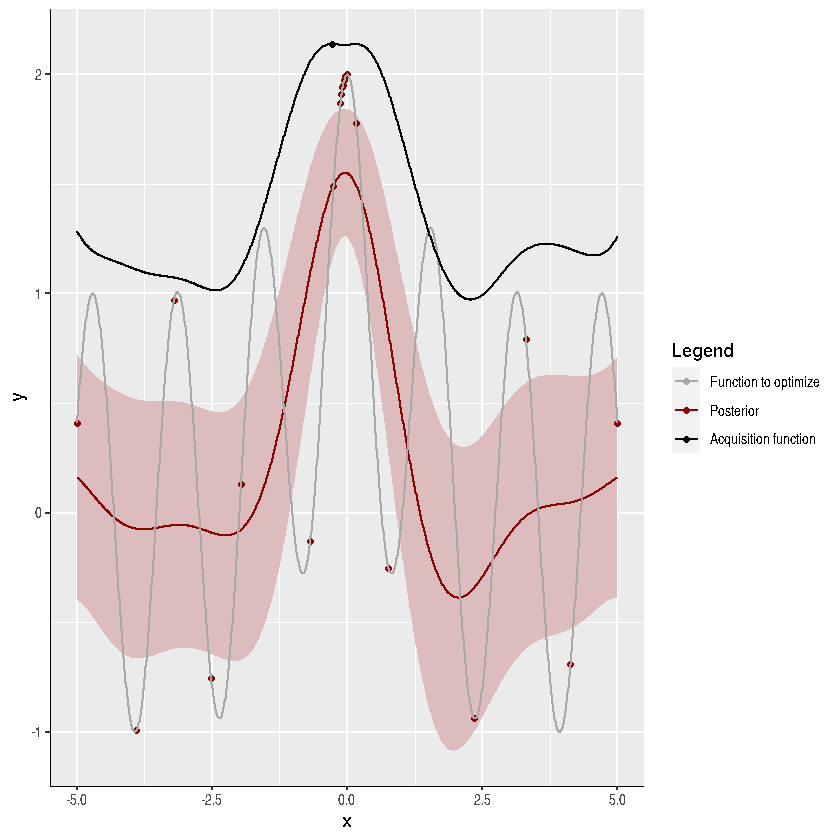

In [56]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

## Batch Bayesian optimization

In cases where we want to query multiple points at once, we need to come up with another strategy. One way to do that is, to propose a new point, then penalize the acquisition function around the region of the proposed point, and then propose another point by using the penalized acquisition function.

Below we demonstrate the proposed method by [Gonzales *et al.*](http://proceedings.mlr.press/v51/gonzalez16a.pdf).

First we define some required functions.

In [68]:
m <- function(gp, x.d, y.d, x.init) {
    pred <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- pred[[1]]
    max(f.star)
}

We approximate the gradient of the posterior predictive mean using finite differences.

In [73]:
posterior.gradient <- function(gp, x.d, y.d, x.init) {
    h <- 0.00000000001
    f.star <- predict.gp(gp, x.d, y.d, x.init)[[1]]
    f.h.star <- predict.gp(gp, x.d, y.d, x.init + h)[[1]]
    f.star.grad <- (f.h.star - f.star) / h
    
    list(f.star=f.star, f.star.grad=f.star.grad)
}

In [75]:
lipschitz <- function(gp, x.d, y.d, x.init) {
    f.star.grad <- posterior.gradient(gp, x.d, y.d, x.init)[[2]]
    max(sqrt(f.star.grad ** 2))
}

The function $\phi$ penalizes the acquisiation function around a point $\mathbf{x}_j$.

In [76]:
phi <- function(gp, x.d, y.d, x, x.j, L, M) {
    pred <- predict.gp(gp, x.d, y.d, x.j)
    f.star <- pred[[1]]
    f.star.var <- pred[[2]]
    dist <- rdist::cdist(x, x.j)

    z = (L * dist - M + f.star) / (sqrt(2 * f.star.var))
    z = 0.5 * pracma::erfc(-z)
    z
}

The penalized acquisition function first squashes the value of the original acqusition function and then penalizes this function around the previously proposed points where the width of the penalized region is goverened by $L$ and $M$.

In [100]:
penalized.acquisition <- function(gp, x.d, y.d, x.init, x.t, M, L, conf=2.0) {
    .g <- function(x) {        
        x[x <= 0] <- log(1 + exp(x[x <= 0]))
        x
    }
        
    trans.ucb <- .g(acquisition.function(gp, x.d, y.d, x.init, conf))
    
     penalty <- if (length(x.t) != 0) {
    sapply(x.t, function(x.tj) phi(gp, x.d, y.d, x.init, x.tj, L, M)) %>%
                     apply(., 1, prod)
                     }
                      else {
                          1
                      }
    trans.ucb * penalty
}       

Let's simulate one iteration  $j$ one point at a time. We start again, by simulating an initial data set.

In [133]:
set.seed(23)

x.d <- -4.34934935
y.d <- f(x.d)

We update the surrogate model based on the existing data

Using the surrogate model, we estimate $\hat{L}$ and $\hat{M}$.

In [134]:
pred <- predict.gp(gp, x.d, y.d, x.init)
f.star <- pred[[1]]
f.star.var <- pred[[2]]

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021139 seconds (Sampling)
Chain 1:                0.021139 seconds (Total)
Chain 1: 


In [135]:
M <- m(gp, x.d, y.d, x.init) 
L <- lipschitz(gp, x.d, y.d, x.init)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022309 seconds (Sampling)
Chain 1:                0.022309 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021579 seconds (Sampling)
Chain 1:                0.021579 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.020816 seconds (Sampling)
Chain 1:                0.020816 seconds (Total)
Chain 1: 


We then propose the first point $x_{j1}$:

In [136]:
acqu <- penalized.acquisition(gp,x.d, y.d, x.init, c(), M, L)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022012 seconds (Sampling)
Chain 1:                0.022012 seconds (Total)
Chain 1: 


The first point is the same as before (where we didn't use local penalization), since the penalizer is one, i.e., no region of the acquisition function is reduced.

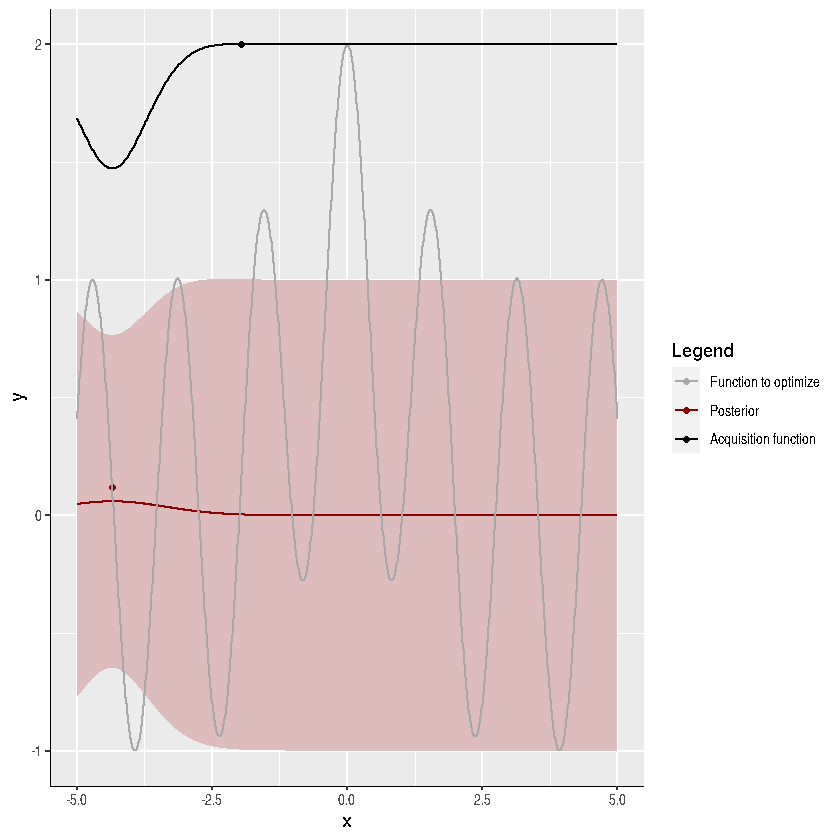

In [137]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=acqu),
              aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.init[which.max(acqu)], y=max(acqu)), aes(x, y))

In [138]:
x.t <- x.init[which.max(acqu)]
acqu.max.t <- max(acqu)

acqu <- penalized.acquisition(gp,x.d, y.d, x.init, x.t, M, L)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022027 seconds (Sampling)
Chain 1:                0.022027 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                8e-06 seconds (Sampling)
Chain 1:                8e-06 seconds (Total)
Chain 1: 


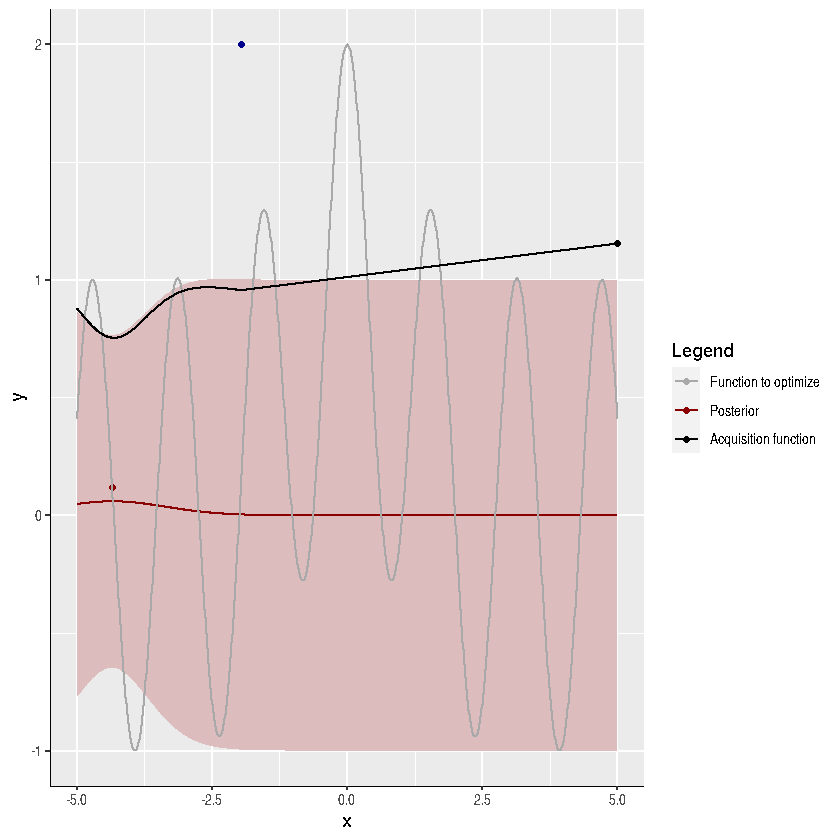

In [139]:
g <- scatterplot(x.init, y.init, 
                 f.star, f.star.var,
                 data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=acqu),
              aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.t, y=acqu.max.t), 
               aes(x, y), color="darkblue") +
    geom_point(data=data.frame(x=x.init[which.max(acqu)], y=max(acqu)), 
               aes(x, y))

More concretely, the acquisition function at the previously selected point is its minimum:

In [140]:
x.t

[1] -1.966967

In [141]:
x.init[which.min(acqu)]

[1] -4.319319

In [142]:
x.t <- c(x.t, x.init[which.max(acqu)])
acqu.max.t <- c(acqu.max.t, max(acqu))

acqu <- penalized.acquisition(gp, x.d, y.d, x.init, x.t, M, L)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022573 seconds (Sampling)
Chain 1:                0.022573 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                8e-06 seconds (Sampling)
Chain 1:                8e-06 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                7e-06 seconds (Sampling)
Chain 1:                7e-06 seconds (Total)
Chain 1: 


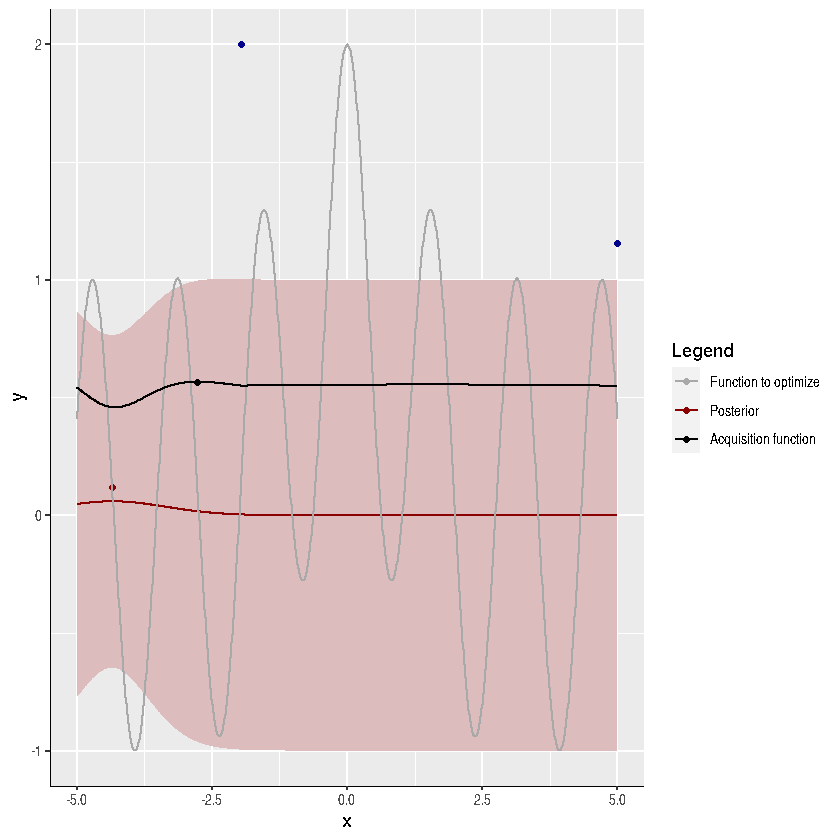

In [143]:
g <- scatterplot(x.init, y.init, 
                 f.star, f.star.var,
                 data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=acqu),
              aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.t, y=acqu.max.t), 
               aes(x, y), color="darkblue") +
    geom_point(data=data.frame(x=x.init[which.max(acqu)], y=max(acqu)), 
               aes(x, y))